## Nature Conservancy Fisheries Monitoring
### Supporting Automated Fish Classification to Help Maintain Ocean Biodiversity
#### Group 1: James Darmody, John Gao, Joanna Wang, Bryan Morgan

#### Project Description
The main goal of this project is to be able to detect which species of fish appears on a fishing boat, based on images captured from boat cameras of various angles.
Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other (meaning that there are fish present but not in the above categories), and No Fish (meaning that no fish is in the picture). Each image has only one fish category, except that there are sometimes very small fish in the pictures that are used as bait. 
The dataset was compiled by The Nature Conservancy in partnership with Satlink, Archipelago Marine Research, the Pacific Community, the Solomon Islands Ministry of Fisheries and Marine Resources, the Australia Fisheries Management Authority, and the governments of New Caledonia and Palau.

#### Data & Features
There are 3777 images in our training data set and 1000 images in our test set.
All of the images in our dataset are color images (RGB), and so all of the features are simply pixels (rows and columns) and channels.
One challenge is that there are images of many different sizes in the dataset, and these will have to be reshaped as part of pre-processing 


#### Algorithm & Hyperparameters
We will need to engage the power of deep learning using a convolutional neural network from the Keras package, using a TensorFlow backend to complete this classification.  The hyperparameters we will tune will include: the number of convolutional layers, the number of activation layers and type of activation used, the number of pooling layers and type of pooling used, the number of pixels and channels for each image (there are many different sizes in the data and all will need to be resized), the loss function, the kernel size, the optimizer, the type of padding and whether it will be used, whether dropout will be used, whether bias will be used, the number of epochs, and batch size.

#### Technical & Societal Objectives
The technical objective of this project will be to limit the multi-class logarithmic loss of our predictions on the test set once we have fitted a functioning convolutional neural network on the training data.
The societal objective will be to develop a workable solution that will help authorities deal with the scope of the problem of overfitting by classifying images from fishing boats using the power of machine learning.

### Loading Pacakges 
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [2]:
# Importing basic packages
import os
import pandas as pd
import numpy as np
import glob
from scipy.misc import imread
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Importing packages for deep learning
import keras
from tensorflow.keras import backend
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Cropping2D
from tensorflow.python.ops.nn import leaky_relu
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from numpy.random import seed
from tensorflow import set_random_seed
from tensorflow.image import rgb_to_grayscale
set_random_seed(2)

### Loading Training & Test Data
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [5]:
# Setting up directory paths and labels for each class in the data
train_directory = '/Users/jamesdarmody/Documents/W207/Final/train/'
test_directory = '/Users/jamesdarmody/Documents/W207/Final/test_stg1/'
fish_labels = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# Training Data loading
train_files = sorted(glob.glob('/Users/jamesdarmody/Documents/W207/Final/train/*/*.jpg'), 
                     key=lambda x: np.random.random())
train = np.array([imread(img) for img in train_files])
print('Length of training data set {}'.format(len(train)))

# Data loading Test
test_files = sorted(glob.glob('/Users/jamesdarmody/Documents/W207/Final/test_stg1/*.jpg'), 
                    key=lambda x: np.random.random())
test = np.array([imread(img) for img in test_files])
print('Length of test data set {}'.format(len(test)))

Length of training data set 3777
Length of test data set 1000


### Loading Sample Images From Data
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

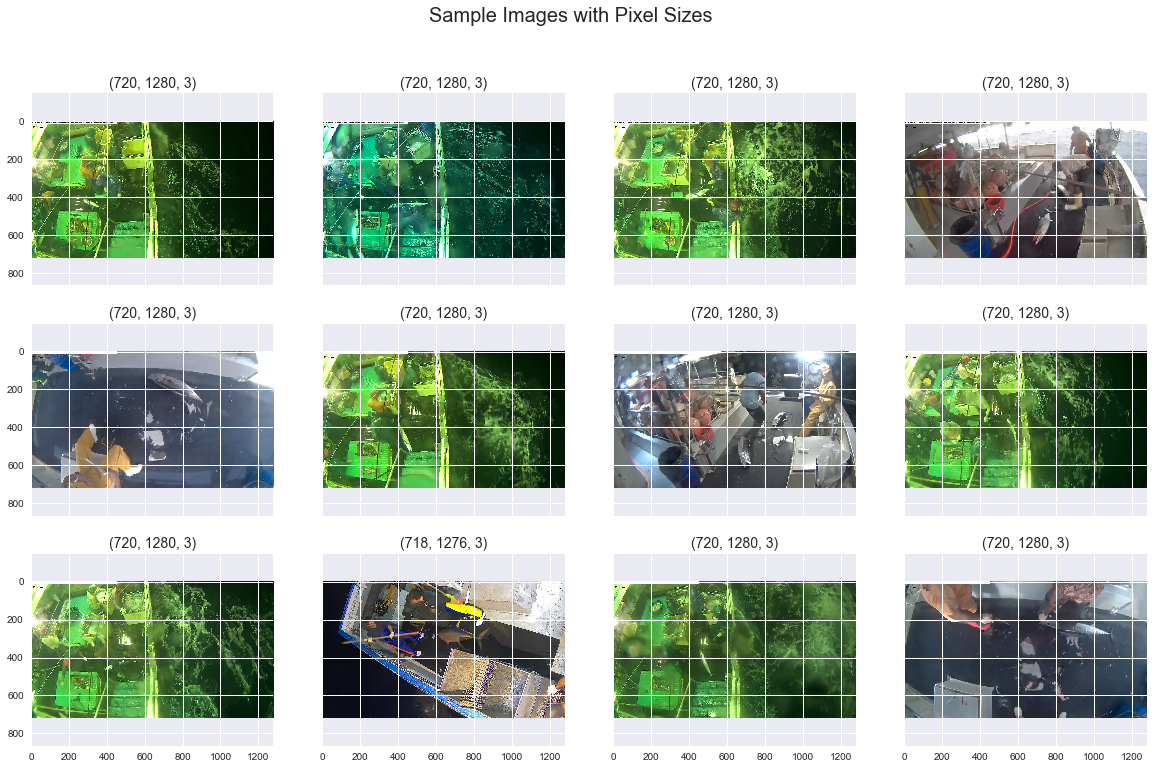

In [18]:
# Function to show a dozen sample images from the data
def sample_dozen(imgs, title):
    random_image_selection = [imgs[np.random.choice(len(imgs))] for _ in range(12)]
    _, ax = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(20, 12))
    plt.suptitle(title, size=20)
    for i, img in enumerate(random_image_selection):
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(img.shape, fontsize=14)
        ax[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=10)
        
sample_dozen(train,  "Sample Images with Pixel Sizes")

### Exploratory Data Analysis
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

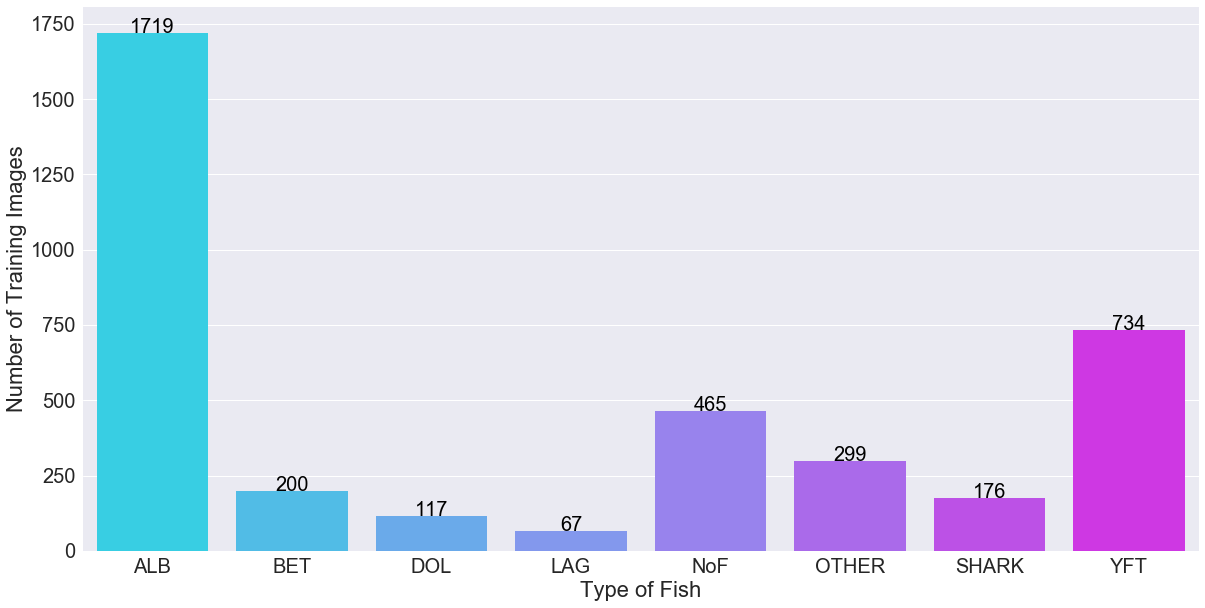

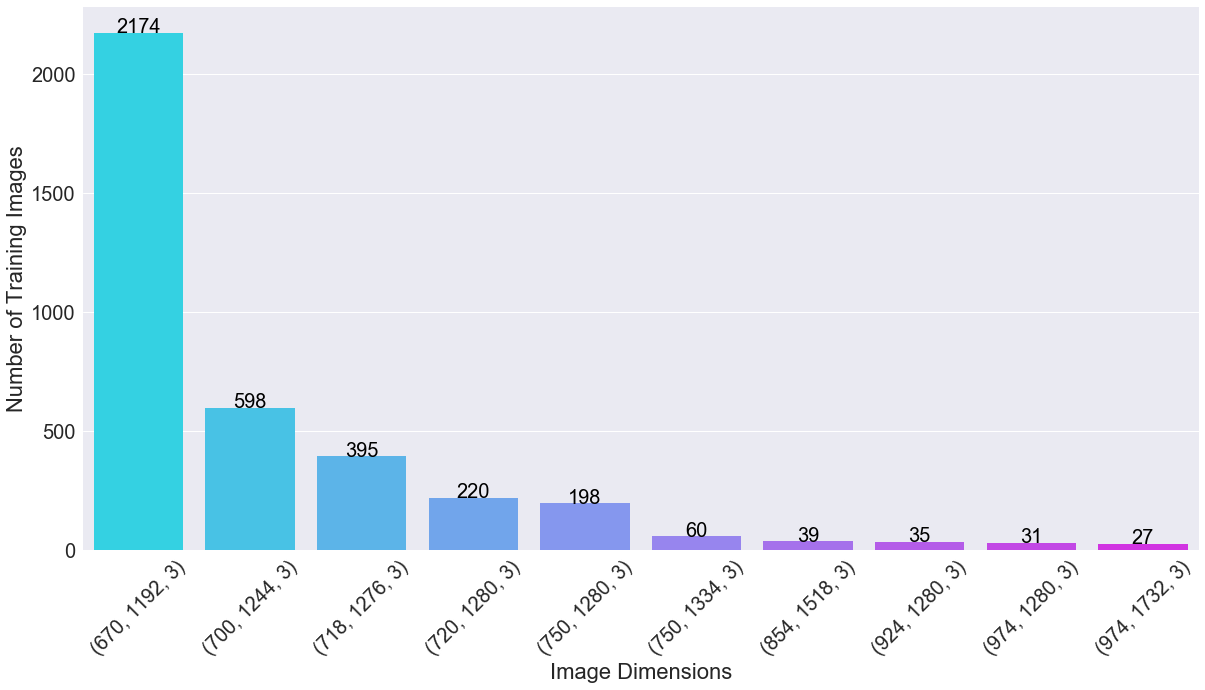

In [7]:
# Define function for reading image files with computer vision package
def get_image(fish):
    fish_dir = train_directory+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return(images)

# Create a bar chart showing number of training images of each type
sns.set_style('darkgrid')
sns.set(font_scale=2)
plt.figure(figsize=(20,10))

total_images = []
for fish in fish_labels:
    fish_species = get_image(fish)
    total_images.append(len(fish_species))
ax_type = sns.barplot(fish_labels, total_images, palette="cool")
ax_type.set(xlabel='Type of Fish', ylabel='Number of Training Images')
for position, number in enumerate(total_images):
    ax_type.text(x=position, y=number, s=number, color='black', ha="center", fontsize=20)
    
    
# Create bar chart showing number of training images of each size 
shapes = np.array([str(img.shape) for img in train])
shape_counts = pd.Series(shapes).value_counts()
sns.set_style('darkgrid')
sns.set(font_scale=2)
plt.figure(figsize=(20,10))

ax_size = sns.barplot(np.unique(shapes), pd.Series(shapes).value_counts(), palette='cool')
ax_size.set(xlabel='Image Dimensions', ylabel='Number of Training Images')
for position, number in enumerate(shape_counts):
    ax_size.text(x=position, y=number, s=number, color='black', ha="center", fontsize=20)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

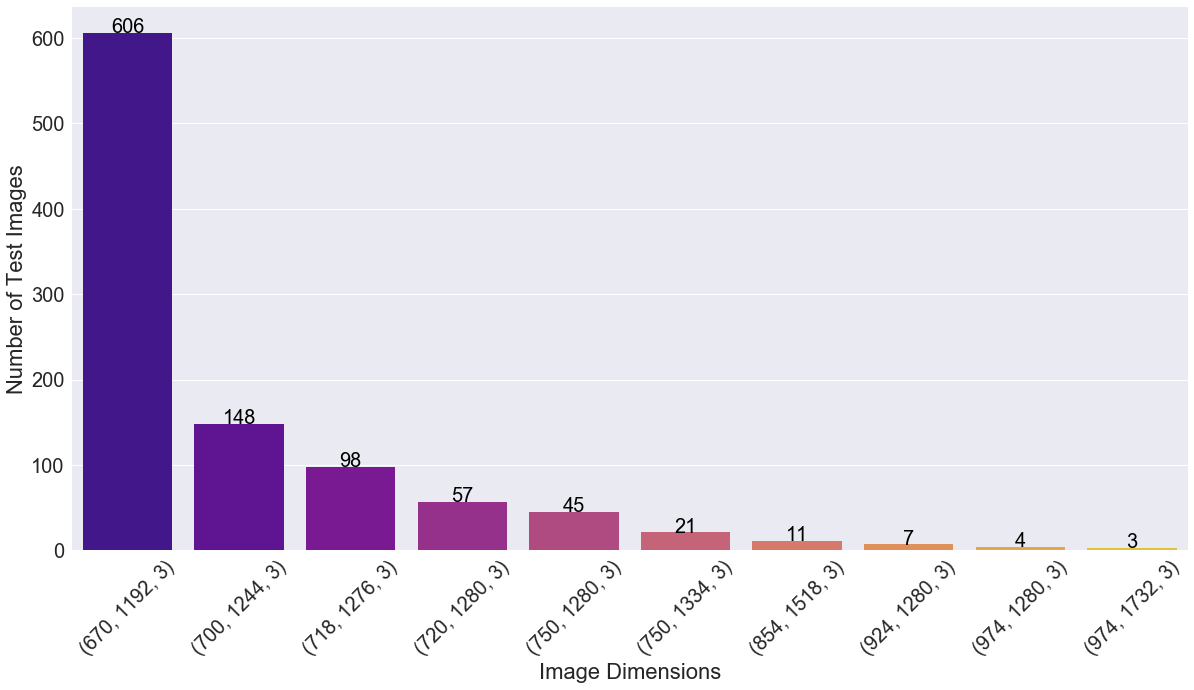

In [19]:
# Create bar chart showing number of test images of each type
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=2)

shapes_test = np.array([str(img.shape) for img in test])
shapes_test_counts = pd.Series(shapes_test).value_counts()
ax_test_size = sns.barplot(np.unique(shapes_test), pd.Series(shapes_test).value_counts(),
                          palette='plasma')
ax_test_size.set(xlabel='Image Dimensions', ylabel='Number of Test Images')
for position, number in enumerate(shapes_test_counts):
    ax_test_size.text(x=position, y=number, s=number, color='black', ha="center", fontsize=20)
plt.xticks(rotation=45)

### Preprocessing Data
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [20]:
# Define function for reading image files with computer vision package

def read_image(src, columns, rows):
    image = cv2.imread(src, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (columns, rows), interpolation=cv2.INTER_LANCZOS4)
    return(image)

# All images for convolutional neural network must be same size
# Specify pixels and channels - larger data means higher accuracy and slower speed 
# A channel is the grayscale image of same size as a color image made of one primary color
# Color images have three channels (red, green, and blue)

column_pixels=124
row_pixels=70
channels=3
grayscale_channels=1

# Loop through files to get lists of all training/test files and all labels associated

total_train_files = []
total_y = []

for fish in fish_labels:
    total_files = get_image(fish)
    total_train_files.extend(total_files)
    y_fish = np.tile(fish, len(total_files))
    total_y.extend(y_fish)
    
y_array = np.array(total_y)
print("Test data shape prior to one-hot encoding: {}".format(y_array.shape))
train_y_one_hot = LabelEncoder().fit_transform(y_array)
train_y_one_hot = np_utils.to_categorical(train_y_one_hot)
print("Test data shape after one-hot encoding: {}".format(train_y_one_hot.shape))

# Define the desired shape of the array of the training files
total_X = np.ndarray((len(total_train_files), row_pixels, column_pixels, channels), dtype=np.uint8)
# Deposit the data into this array, leveraging the function for reading image files
for i, image in enumerate(total_train_files):
    total_X[i] = read_image(train_directory+image, column_pixels, row_pixels)
    
print("Training data shape: {}".format(total_X.shape))

Test data shape prior to one-hot encoding: (3777,)
Test data shape after one-hot encoding: (3777, 8)
Training data shape: (3777, 70, 124, 3)


In [21]:
# Splitting training data from test data
X_train, X_test, y_train, y_test = train_test_split(total_X, 
train_y_one_hot, random_state=0, stratify=train_y_one_hot, test_size=0.2)

# Converting data from int8 to float32 for convolutional neural network model
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [27]:
# Convert images to grayscale to use in second model below
X_train_gray = rgb_to_grayscale(X_train)
print("Grayscale training data: {}".format(X_train_gray.shape))
X_test_gray = rgb_to_grayscale(X_test)
print("Grayscale training data: {}".format(X_test_gray.shape))

# Convert tensor objects to numpy arrays for CNN
import tensorflow as tf
sess = tf.Session()
X_train_gray_array = X_train_gray.eval(session=sess)
X_train_gray_array = X_train_gray_array.astype('float32')
X_test_gray_array = X_test_gray.eval(session=sess)
X_test_gray_array = X_test_gray_array.astype('float32')

Grayscale training data: (3021, 70, 124, 1)
Grayscale training data: (756, 70, 124, 1)


### Establishing a Baseline
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

Baseline Accuracy: 0.1204
Baseline Log Loss: 15.07955286364076
##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##
Classification Report for Baseline Accuracy
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       344
           1       0.04      0.05      0.04        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        13
           4       0.14      0.14      0.14        93
           5       0.10      0.07      0.08        60
           6       0.00      0.00      0.00        35
           7       0.23      0.24      0.24       147

   micro avg       0.27      0.26      0.27       756
   macro avg       0.12      0.11      0.12       756
weighted avg       0.27      0.26      0.27       756
 samples avg       0.19      0.26      0.21       756

##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##
Confusion Matrix for Baseline Accuracy

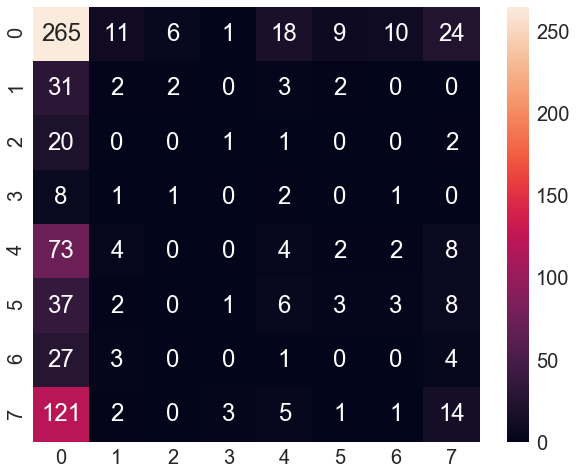

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# A baseline classifier that will make predictions roughly in proportion with the incidences found in the data
dummy = DummyClassifier(strategy='stratified', random_state=0)
baseline_fitted = dummy.fit(X_train, y_train)
baseline_predict = dummy.predict(X_test)
baseline_score = dummy.score(X_test, y_test)
print("Baseline Accuracy: {}".format(round(baseline_score,4)))
print("Baseline Log Loss: {}".format(log_loss(y_test, baseline_predict)))
print('##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##')

print('Classification Report for Baseline Accuracy')
print(classification_report(y_test, baseline_predict))

print('##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##')
print('Confusion Matrix for Baseline Accuracy')
baseline_confusion = confusion_matrix(y_test.argmax(axis=1), 
                       baseline_predict.argmax(axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(baseline_confusion, annot=True, fmt="d");

Baseline Accuracy Grayscale: 0.1204
Baseline Log Loss Grayscale: 15.07955286364076
##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##
Classification Report for Baseline Accuracy
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       344
           1       0.04      0.05      0.04        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        13
           4       0.14      0.14      0.14        93
           5       0.10      0.07      0.08        60
           6       0.00      0.00      0.00        35
           7       0.23      0.24      0.24       147

   micro avg       0.27      0.26      0.27       756
   macro avg       0.12      0.11      0.12       756
weighted avg       0.27      0.26      0.27       756
 samples avg       0.19      0.26      0.21       756

##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##
Confusion Matrix f

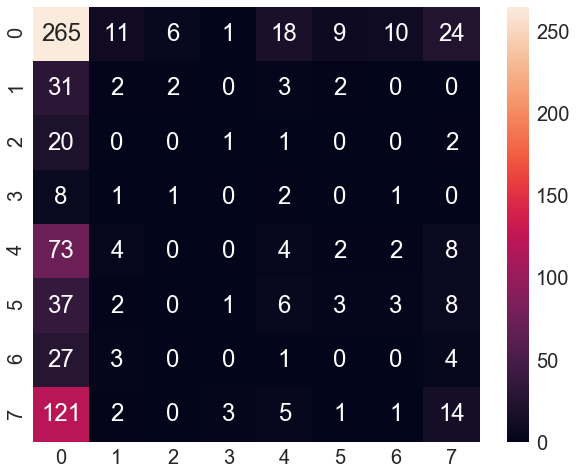

In [28]:
# A baseline classifier that will make predictions roughly in proportion with the incidences found in the data
dummy_gray = DummyClassifier(strategy='stratified', random_state=0)
baseline_fitted_gray = dummy.fit(X_train_gray_array, y_train)
baseline_predict_gray = dummy.predict(X_test_gray_array)
baseline_score_gray = dummy.score(X_test_gray_array, y_test)
print("Baseline Accuracy Grayscale: {}".format(round(baseline_score_gray,4)))
print("Baseline Log Loss Grayscale: {}".format(log_loss(y_test, baseline_predict_gray)))
print('##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##')

print('Classification Report for Baseline Accuracy')
print(classification_report(y_test, baseline_predict_gray))

print('##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##')
print('Confusion Matrix for Baseline Accuracy')
baseline_confusion_gray = confusion_matrix(y_test.argmax(axis=1), 
                       baseline_predict_gray.argmax(axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(baseline_confusion_gray, annot=True, fmt="d");

#### Baseline Discussion
The baseline is able to correcty classify with approximately 12% accuracy and a logloss of approximately 15 (the closer to zero the better).  Given that we have 8 classes in our data, this accuracy is almost exactly on a par with pure random chance, so the goal of our convolutional neural network will be to improve upon this and minimize logloss.  In addition, in order to prevent overfishing, false negatives are far more harmful than false positives.
For instance, if an algorithm wrongly identifies a boat as overfishing, it will be a minor inconvenience for the boat in question to show their catch to authorities and resolve the issue.  However, a false negative would allow a boat to get away with overfishing, and therefore this model should seek to maximize recall.  Lastly, the baseline is provided for both RGB and grayscale, but there is no difference

### Model 1: RGB
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [29]:
# Define a function that normalizes data using the Tensorflow backend
def normalize_data(x):
    return (x - K.mean(x)) / K.std(x)

In [30]:
# Instantiate the model
fish_model = Sequential()
# Start by cropping the data to cut down on extraneous features
fish_model.add(Cropping2D(cropping=((2,2), (2,2)), input_shape=(row_pixels, column_pixels, channels) ))

# Add an Activation layer that normalizes data and sets the shape of all inputs according to preprocessing specifications for pixels and channels
fish_model.add(Activation(activation=normalize_data))

# Add an activation layer with rectified linear unit - transforms data to max of 0 or input itself
# Add first convolutional layer that uses padding to ensure all pixels get due focus
# Use bias - increases flexibility of model by determining when neurons are activated by adding a weight to weighted sum
# Add the first convolutional layer with 32 filters (dimensionality of output space), 3x3 kernel that uses relu, padding, and bias
fish_model.add(Activation('relu'))
fish_model.add(Conv2D(32,kernel_size=(3,3), activation='relu', padding='same', use_bias=True))

# Not employing pooling within the first two layers allows for more complete training by preserving features until later, but much slower
fish_model.add(Activation('relu'))
fish_model.add(Conv2D(64,(3,3), activation='relu', padding='same'))

# Replicate the previous layer with 128 filters and the addition of MaxPooling using a 2x2 pool
# Add dropout to prevent overfitting by randomly removing some features and forcing model to relearn
fish_model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))
fish_model.add(Dropout(0.2))

# Same as previous layer, but with 256 filters
fish_model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))
fish_model.add(Dropout(0.2))

# After the fourth convolutional layer and pooling, flatten the output into one column
fish_model.add(Flatten())
# First fully connected layer - layer of neurons connected by dot product of input with kernel and passed through activation function
fish_model.add(Dense(256, activation='relu'))
# Second fully connected layer has 8 inputs because that is the number of classes in the data
# Softmax creates a probability vector for multi-class classification
fish_model.add(Dense(8, activation='softmax'))
# Monitoring validation loss, if an epoch passes and this does not improve, stop the training
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')

In [31]:
# Compile the model using categorical crossentropy to deal with multiclass classification
# Adam optimizer shows best results - combines advantages of AdaGrad and RMSProp optimizers
# Report accuracy
fish_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',
                   metrics=['accuracy'])

In [32]:
# Fit the model on training data using a bactch size of 64 (standard)
# Use 10 epochs as default with the ability to stop early with diminshing returns on validation
overfish = fish_model.fit(X_train, y_train, batch_size=64, epochs=10,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 2416 samples, validate on 605 samples
Epoch 1/10
2416/2416 [==============================] - 386s 160ms/step - loss: 1.8166 - acc: 0.4884 - val_loss: 1.1648 - val_acc: 0.5686
Epoch 2/10
2416/2416 [==============================] - 332s 137ms/step - loss: 0.7741 - acc: 0.7471 - val_loss: 0.6180 - val_acc: 0.8198
Epoch 3/10
2416/2416 [==============================] - 326s 135ms/step - loss: 0.2718 - acc: 0.9131 - val_loss: 0.4001 - val_acc: 0.8860
Epoch 4/10
2416/2416 [==============================] - 1580s 654ms/step - loss: 0.1191 - acc: 0.9644 - val_loss: 0.4136 - val_acc: 0.9107
Epoch 00004: early stopping


In [33]:
# Display a visual summary of the model's layers and parameters
fish_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 66, 120, 3)        0         
_________________________________________________________________
activation_3 (Activation)    (None, 66, 120, 3)        0         
_________________________________________________________________
activation_4 (Activation)    (None, 66, 120, 3)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 66, 120, 32)       896       
_________________________________________________________________
activation_5 (Activation)    (None, 66, 120, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 66, 120, 64)       18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 66, 120, 128)      73856     
__________

In [34]:
# After training, predict on the test set, reporting logloss (which we seek to minimize)
prediction = fish_model.predict(X_test, verbose=1)
print("Validation Log Loss: {}".format(log_loss(y_test, prediction)))

756/756 [==============================] - 44s 58ms/step
Validation Log Loss: 0.2976813446213345


### Model 2: Grayscale
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [13]:
# Instantiate the model
fish_model_gray = Sequential()
# Start by cropping the data to cut down on extraneous features
fish_model_gray.add(Cropping2D(cropping=((2,2), (2,2)), input_shape=(row_pixels, column_pixels, grayscale_channels) ))

# Add an Activation layer that normalizes data and sets the shape of all inputs according to preprocessing specifications for pixels and channels
fish_model_gray.add(Activation(activation=normalize_data))

# Add an activation layer with rectified linear unit - transforms data to max of 0 or input itself
# Add first convolutional layer that uses padding to ensure all pixels get due focus
# Use bias - increases flexibility of model by determining when neurons are activated by adding a weight to weighted sum
# Add the first convolutional layer with 32 filters (dimensionality of output space), 3x3 kernel that uses relu, padding, and bias
fish_model_gray.add(Activation('relu'))
fish_model_gray.add(Conv2D(32,kernel_size=(3,3), activation='relu', padding='same', use_bias=True))

# Not employing pooling within the first two layers allows for more complete training by preserving features until later, but much slower
fish_model_gray.add(Activation('relu'))
fish_model_gray.add(Conv2D(64,(3,3), activation='relu', padding='same'))

# Replicate the previous layer with 128 filters and the addition of MaxPooling using a 2x2 pool
# Add dropout to prevent overfitting by randomly removing some features and forcing model to relearn
fish_model_gray.add(Conv2D(128,(3,3), activation='relu', padding='same'))
fish_model_gray.add(MaxPooling2D(pool_size=(2,2)))
fish_model_gray.add(Dropout(0.2))

# Same as previous layer, but with 256 filters
fish_model_gray.add(Conv2D(256,(3,3), activation='relu', padding='same'))
fish_model_gray.add(MaxPooling2D(pool_size=(2,2)))
fish_model_gray.add(Dropout(0.2))

# After the fourth convolutional layer and pooling, flatten the output into one column
fish_model_gray.add(Flatten())
# First fully connected layer - layer of neurons connected by dot product of input with kernel and passed through activation function
fish_model_gray.add(Dense(256, activation='relu'))
# Second fully connected layer has 8 inputs because that is the number of classes in the data
# Softmax creates a probability vector for multi-class classification
fish_model_gray.add(Dense(8, activation='softmax'))
# Monitoring validation loss, if an epoch passes and this does not improve, stop the training
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')

In [14]:
# Compile the model using categorical crossentropy to deal with multiclass classification
# Adam optimizer shows best results - combines advantages of AdaGrad and RMSProp optimizers
# Report accuracy
fish_model_gray.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',
                   metrics=['accuracy'])

In [15]:
# Fit the model on training data using a bactch size of 64 (standard)
# Use 10 epochs as default with the ability to stop early with diminshing returns on validation
overfish_gray = fish_model_gray.fit(X_train_gray_array, y_train, batch_size=64, epochs=10,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 2416 samples, validate on 605 samples
Epoch 1/10
2416/2416 [==============================] - 356s 147ms/step - loss: 1.7796 - acc: 0.4528 - val_loss: 1.3501 - val_acc: 0.5207
Epoch 2/10
2416/2416 [==============================] - 323s 134ms/step - loss: 1.0810 - acc: 0.6275 - val_loss: 0.9006 - val_acc: 0.7306
Epoch 3/10
2416/2416 [==============================] - 335s 139ms/step - loss: 0.5744 - acc: 0.8187 - val_loss: 0.5089 - val_acc: 0.8612
Epoch 4/10
2416/2416 [==============================] - 338s 140ms/step - loss: 0.2663 - acc: 0.9131 - val_loss: 0.3893 - val_acc: 0.9107
Epoch 5/10
2416/2416 [==============================] - 323s 134ms/step - loss: 0.1168 - acc: 0.9599 - val_loss: 0.4208 - val_acc: 0.9124
Epoch 00005: early stopping


In [36]:
# Display a visual summary of the model's layers and parameters
fish_model_gray.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 66, 120, 1)        0         
_________________________________________________________________
activation (Activation)      (None, 66, 120, 1)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 66, 120, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 66, 120, 32)       320       
_________________________________________________________________
activation_2 (Activation)    (None, 66, 120, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 120, 64)       18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 120, 128)      73856     
__________

In [35]:
# After training, predict on the test set, reporting logloss (which we seek to minimize)
prediction_gray = fish_model_gray.predict(X_test_gray_array, verbose=1)
print("Validation Log Loss Grayscale: {}".format(log_loss(y_test, prediction_gray)))

756/756 [==============================] - 40s 52ms/step
Validation Log Loss Grayscale: 0.3333505303601569


### Examining Results
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

Classification Report for RGB Model Accuracy
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       344
           1       0.92      0.88      0.90        40
           2       0.95      0.83      0.89        24
           3       0.87      1.00      0.93        13
           4       0.91      0.88      0.90        93
           5       0.93      0.95      0.94        60
           6       1.00      0.97      0.99        35
           7       0.91      0.93      0.92       147

   micro avg       0.93      0.93      0.93       756
   macro avg       0.93      0.92      0.92       756
weighted avg       0.93      0.93      0.93       756



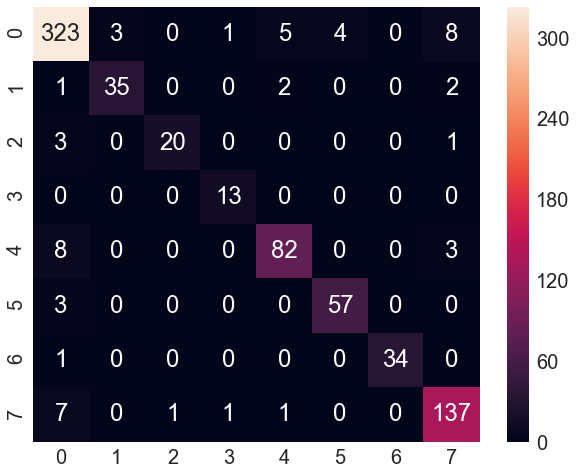

In [37]:
# Classification report for test set, recall should be materially higher than baseline
prediction_max = np.argmax(prediction, axis=1)
y_test_max = np.argmax(y_test, axis=1)
print('Classification Report for RGB Model Accuracy')
print(classification_report(y_test_max, prediction_max))

# Confusion matrix should be much closer to diagonal than baseline confusion matrix
validation_confusion = confusion_matrix(y_test_max, prediction_max)
plt.figure(figsize=(10,8))
sns.heatmap(validation_confusion, annot=True, fmt="d");

Classification Report for Grayscale Model Accuracy
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       344
           1       0.92      0.90      0.91        40
           2       0.78      0.88      0.82        24
           3       1.00      1.00      1.00        13
           4       0.96      0.86      0.91        93
           5       0.92      0.97      0.94        60
           6       1.00      0.94      0.97        35
           7       0.93      0.88      0.90       147

   micro avg       0.93      0.93      0.93       756
   macro avg       0.93      0.92      0.92       756
weighted avg       0.93      0.93      0.93       756



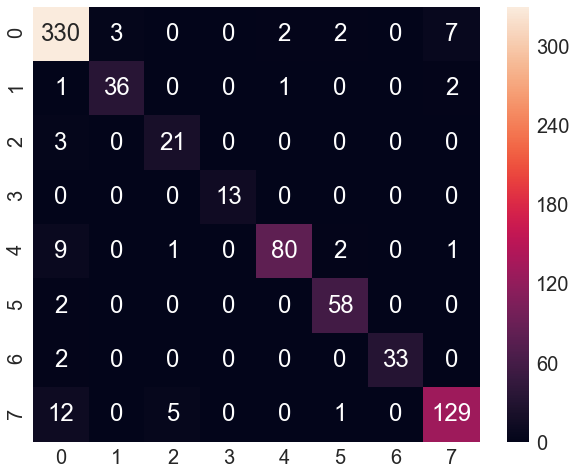

In [38]:
# Classification report for test set, recall should be materially higher than baseline
prediction_max_gray = np.argmax(prediction_gray, axis=1)
y_test_max_gray = np.argmax(y_test, axis=1)
print('Classification Report for Grayscale Model Accuracy')
print(classification_report(y_test_max_gray, prediction_max_gray))

# Confusion matrix should be much closer to diagonal than baseline confusion matrix
validation_confusion_gray = confusion_matrix(y_test_max_gray, prediction_max_gray)
plt.figure(figsize=(10,8))
sns.heatmap(validation_confusion_gray, annot=True, fmt="d");

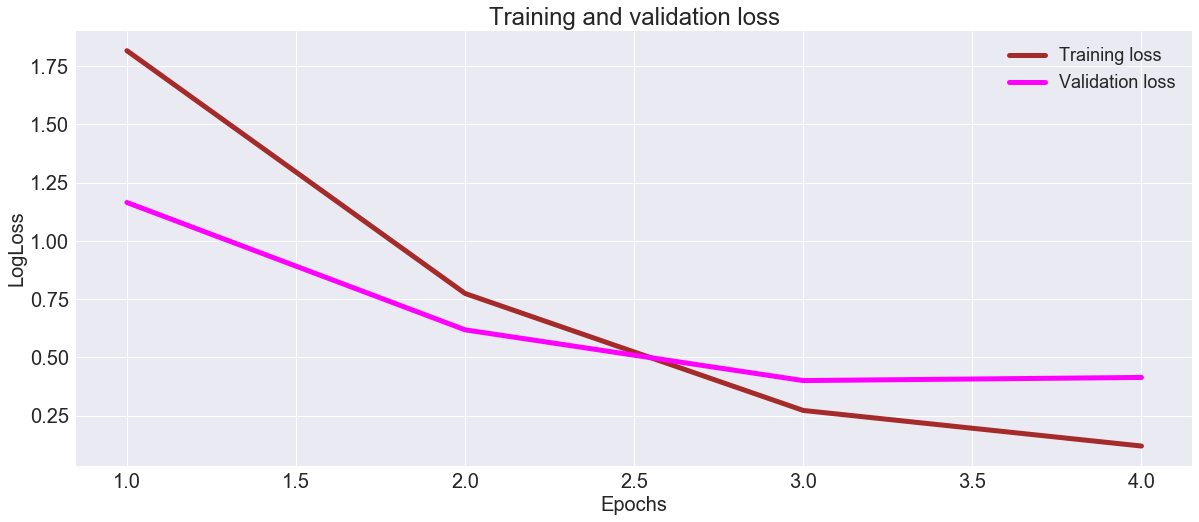

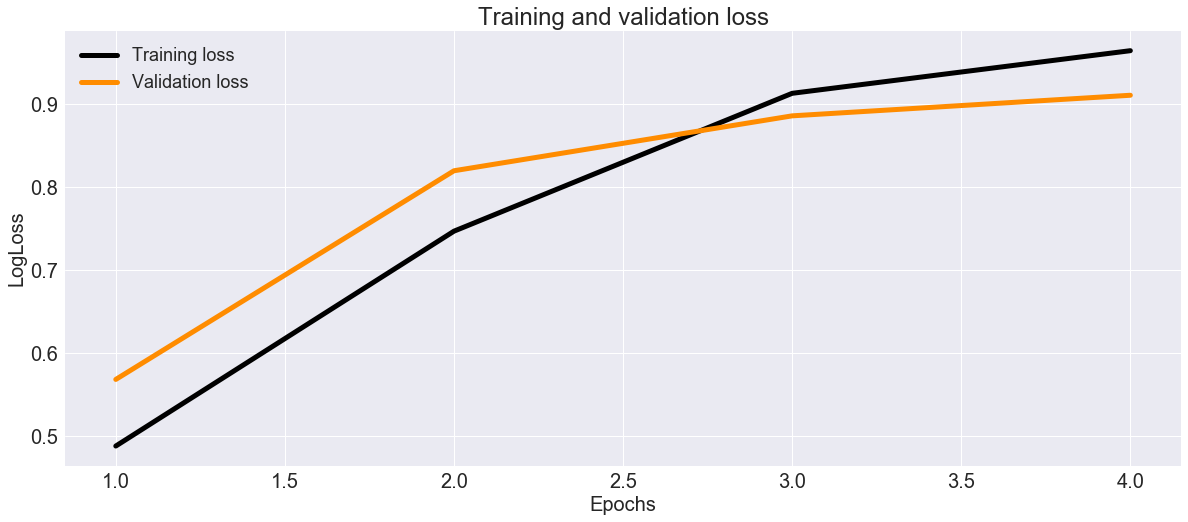

In [39]:
# setting up a plot for RGB logloss versus epochs
validation_figure, validation_plot = plt.subplots(figsize=(20,8))
loss = overfish.history['loss']
val_loss = overfish.history['val_loss']
epochs = range(1, len(loss) + 1)
validation_plot.plot(epochs, loss, color='brown', label='Training loss', linewidth=5)
validation_plot.plot(epochs, val_loss, color='magenta', label='Validation loss', linewidth=5)
plt.title('Training and validation loss', fontsize=24)
validation_plot.set_xlabel('Epochs', fontsize=20)
validation_plot.set_ylabel('LogLoss', fontsize=20)
validation_plot.legend(fontsize=18)

# setting up a plot for RGB accuracy versus epochs
accuracy_figure, accuracy_plot = plt.subplots(figsize=(20,8))
accuracy = overfish.history['acc']
val_accuracy = overfish.history['val_acc']
epochs = range(1, len(loss) + 1)
accuracy_plot.plot(epochs, accuracy, color='black', label='Training loss', linewidth=5)
accuracy_plot.plot(epochs, val_accuracy, color='darkorange', label='Validation loss', linewidth=5)
plt.title('Training and validation accuracy', fontsize=24)
accuracy_plot.set_xlabel('Epochs', fontsize=20)
accuracy_plot.set_ylabel('LogLoss', fontsize=20)
accuracy_plot.legend(fontsize=18)

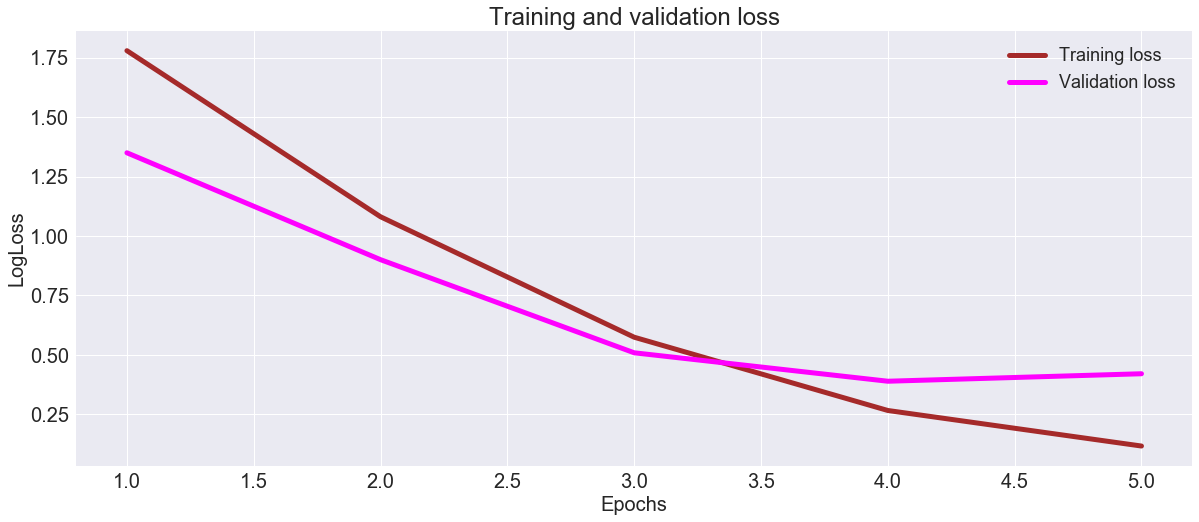

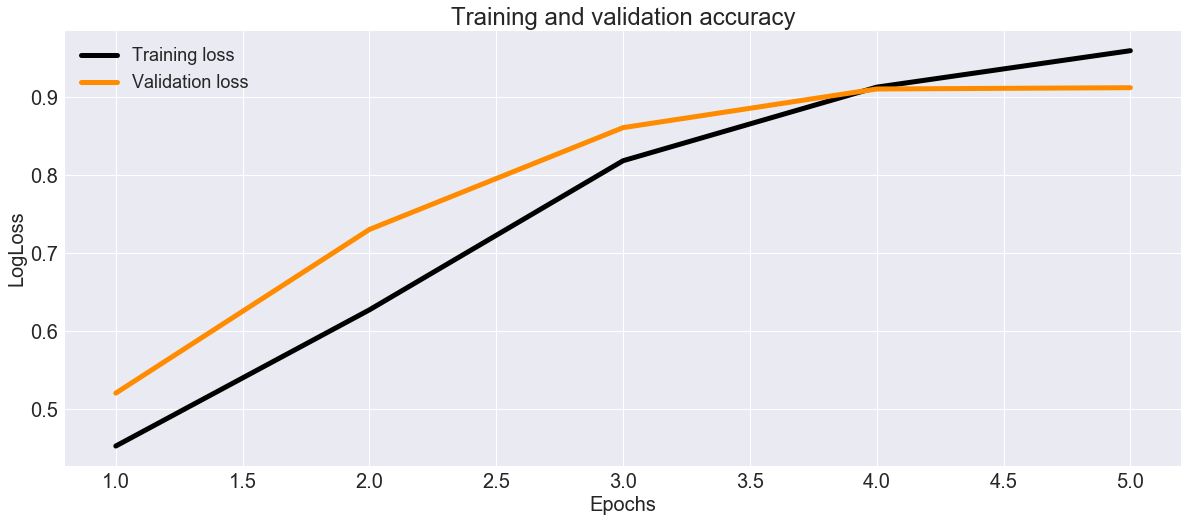

In [42]:
# setting up a plot for Grayscale logloss versus epochs
validation_figure_gray, validation_plot_gray = plt.subplots(figsize=(20,8))
loss_gray = overfish_gray.history['loss']
val_loss_gray = overfish_gray.history['val_loss']
epochs_gray = range(1, len(loss_gray) + 1)
validation_plot_gray.plot(epochs_gray, loss_gray, color='brown', label='Training loss', linewidth=5)
validation_plot_gray.plot(epochs_gray, val_loss_gray, color='magenta', label='Validation loss', linewidth=5)
plt.title('Training and validation loss', fontsize=24)
validation_plot_gray.set_xlabel('Epochs', fontsize=20)
validation_plot_gray.set_ylabel('LogLoss', fontsize=20)
validation_plot_gray.legend(fontsize=18)

# setting up a plot for Grayscale accuracy versus epochs
accuracy_figure_gray, accuracy_plot_gray = plt.subplots(figsize=(20,8))
accuracy_gray = overfish_gray.history['acc']
val_accuracy_gray = overfish_gray.history['val_acc']
epochs_gray = range(1, len(loss_gray) + 1)
accuracy_plot_gray.plot(epochs_gray, accuracy_gray, color='black', label='Training loss', linewidth=5)
accuracy_plot_gray.plot(epochs_gray, val_accuracy_gray, color='darkorange', label='Validation loss', linewidth=5)
plt.title('Training and validation accuracy', fontsize=24)
accuracy_plot_gray.set_xlabel('Epochs', fontsize=20)
accuracy_plot_gray.set_ylabel('LogLoss', fontsize=20)
accuracy_plot_gray.legend(fontsize=18)

In [43]:
layer_outputs = [layer.output for layer in fish_model.layers]
activation_model = Model(inputs=fish_model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[25].reshape(1,row_pixels,column_pixels,channels))
 
def display_activation(activations, col_size, row_size, act_index, suptitle): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    fig.suptitle(suptitle, fontsize=20)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='seismic')
            ax[row][col].tick_params(axis='both', which='major', labelsize=10)
            activation_index += 1

In [44]:
layer_outputs

[<tf.Tensor 'cropping2d_1/strided_slice:0' shape=(?, 66, 120, 3) dtype=float32>,
 <tf.Tensor 'activation_3/truediv:0' shape=(?, 66, 120, 3) dtype=float32>,
 <tf.Tensor 'activation_4/Relu:0' shape=(?, 66, 120, 3) dtype=float32>,
 <tf.Tensor 'conv2d_4/Relu:0' shape=(?, 66, 120, 32) dtype=float32>,
 <tf.Tensor 'activation_5/Relu:0' shape=(?, 66, 120, 32) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu:0' shape=(?, 66, 120, 64) dtype=float32>,
 <tf.Tensor 'conv2d_6/Relu:0' shape=(?, 66, 120, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 33, 60, 128) dtype=float32>,
 <tf.Tensor 'dropout_2/cond/Merge:0' shape=(?, 33, 60, 128) dtype=float32>,
 <tf.Tensor 'conv2d_7/Relu:0' shape=(?, 33, 60, 256) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 16, 30, 256) dtype=float32>,
 <tf.Tensor 'dropout_3/cond/Merge:0' shape=(?, 16, 30, 256) dtype=float32>,
 <tf.Tensor 'flatten_1/Reshape:0' shape=(?, 122880) dtype=float32>,
 <tf.Tensor 'dense_2/Relu:0' shape=(?, 256) 

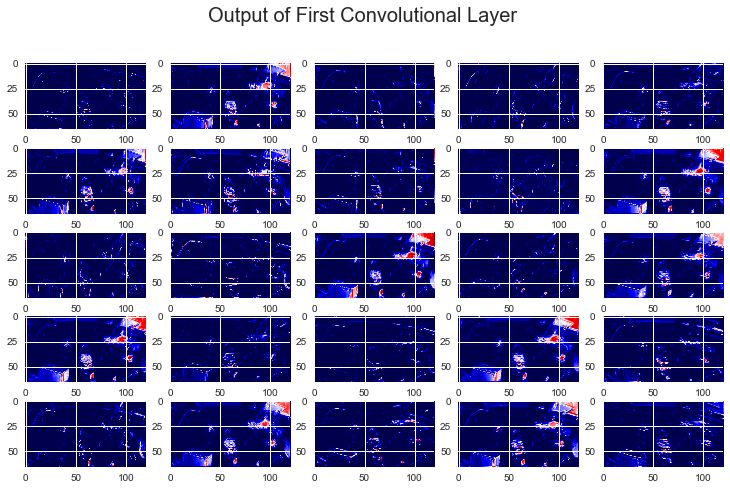

In [45]:
display_activation(activations, 5, 5, 3, "Output of First Convolutional Layer")

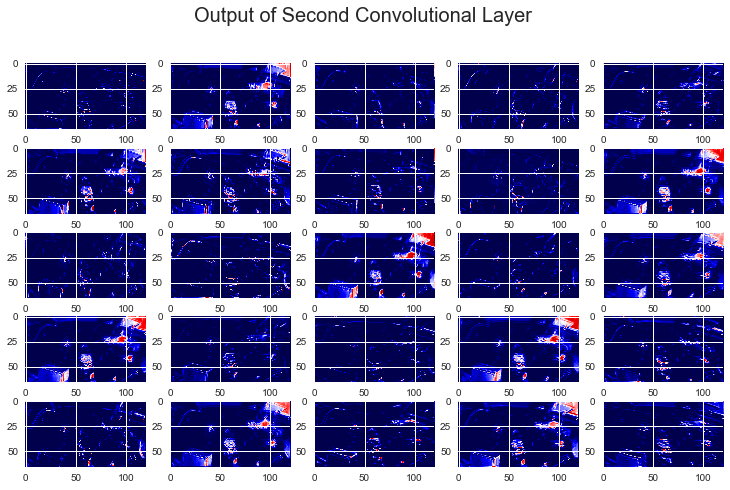

In [46]:
display_activation(activations, 5, 5, 4, "Output of Second Convolutional Layer")

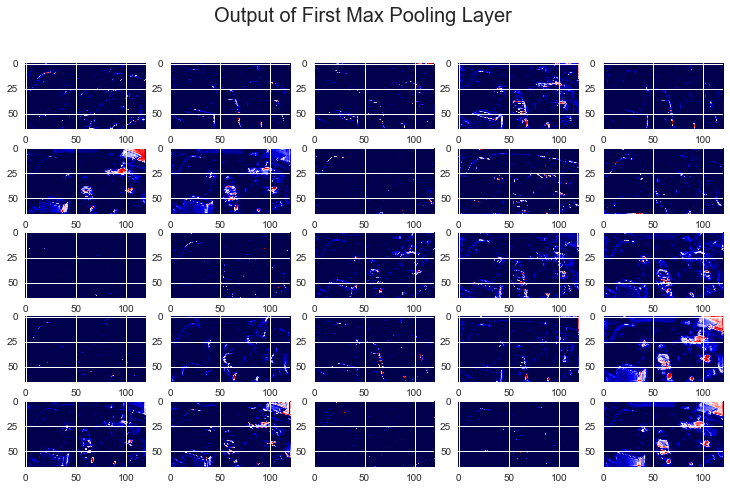

In [47]:
display_activation(activations, 5, 5, 5, "Output of First Max Pooling Layer")

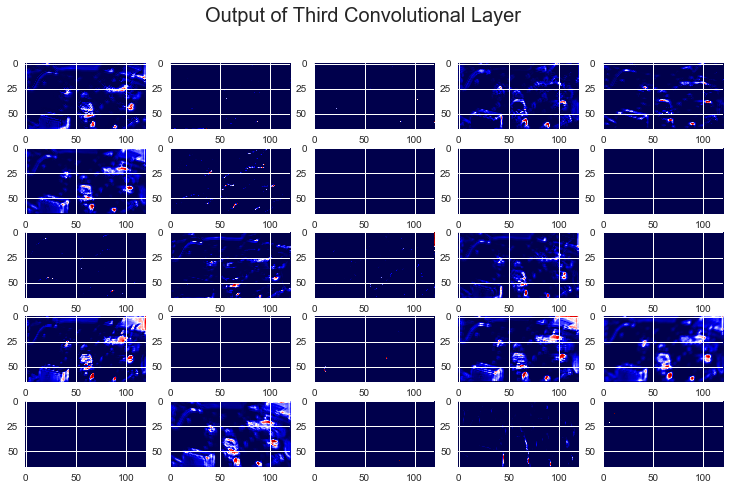

In [48]:
display_activation(activations, 5, 5, 6, "Output of Third Convolutional Layer")

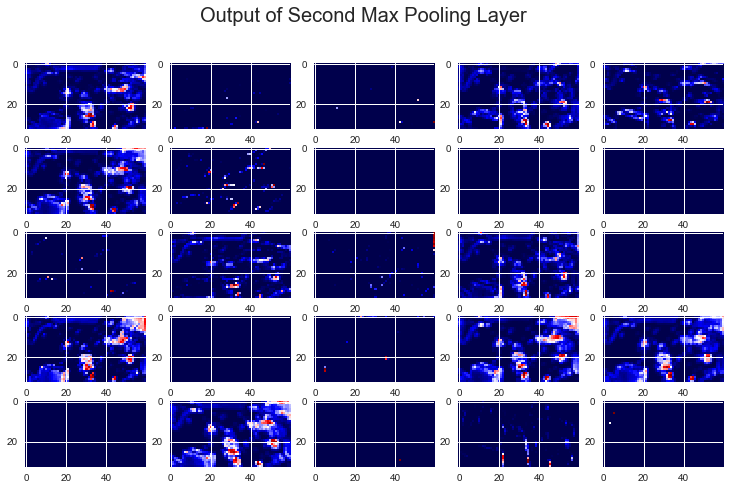

In [49]:
display_activation(activations, 5, 5, 7, "Output of Second Max Pooling Layer")

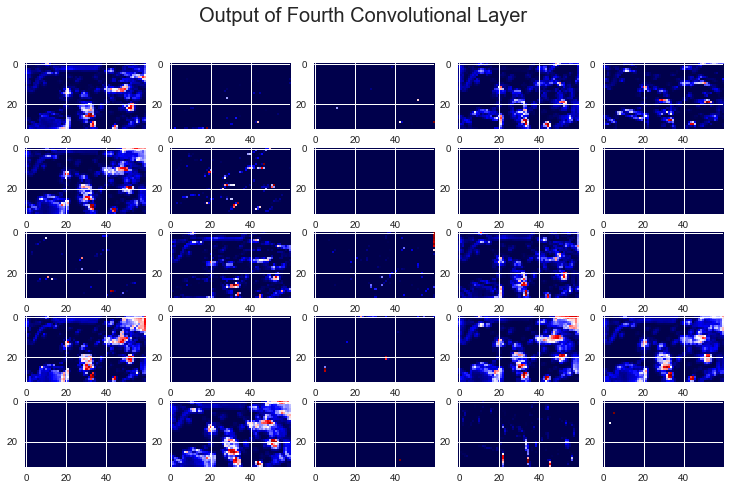

In [50]:
display_activation(activations, 5, 5, 8, "Output of Fourth Convolutional Layer")

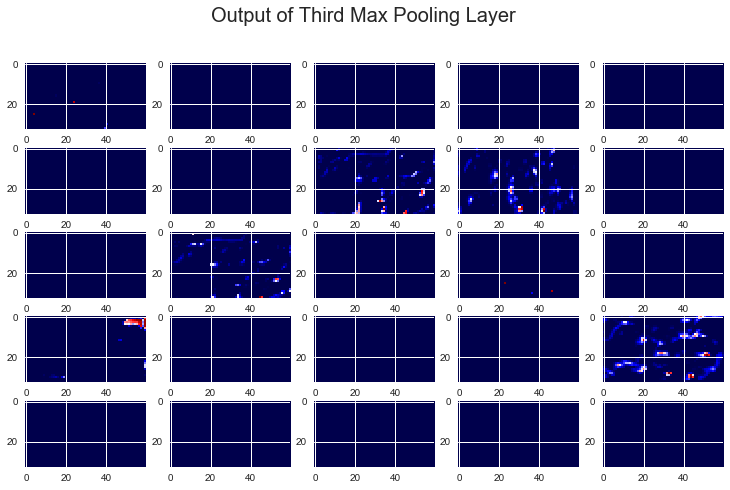

In [51]:
display_activation(activations, 5, 5, 9, "Output of Third Max Pooling Layer")

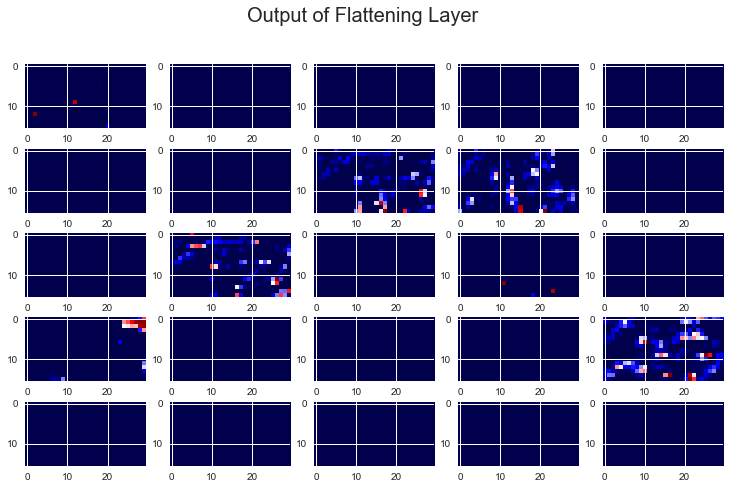

In [52]:
display_activation(activations, 5, 5, 10, "Output of Flattening Layer")

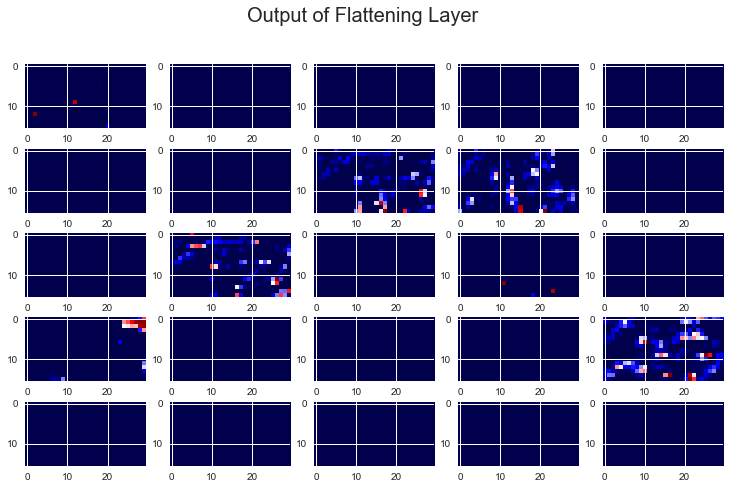

In [53]:
display_activation(activations, 5, 5, 11, "Output of Flattening Layer")